In [1]:
import os 
# os.environ["GPU"] = "1"
# os.environ["CLANG"] = "1"
import numpy as np
import tqdm

from tinygrad.tensor import Tensor
from tinygrad.nn import optim
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt    
from model import Model

In [2]:
def sin_gen():
    while True:
        x = np.random.random(1)*2*np.pi - np.pi
        y = np.sin(x)+ np.random.randn(1)*0.01
        yield x, y

def sin_eval():
    while True:
        x = np.random.random(1)*2*np.pi - np.pi
        y = np.sin(x)
        yield x, y

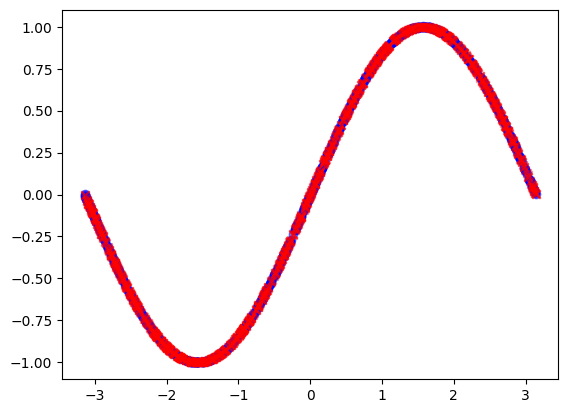

In [3]:
# plot the dict
x,y = [],[]
x__, y__ = [ ], [ ]
for i in range(1000):
    x_, y_ = next(sin_gen())
    x___, y___ = next(sin_eval())
    x__.append(x___)
    y__.append(y___)
    x.append(x_)
    y.append(y_)

plt.scatter(x, y, label = "train", color = "blue", alpha=0.5)
plt.scatter(x__, y__, label = "eval", color = "red", alpha=0.5, marker='x')

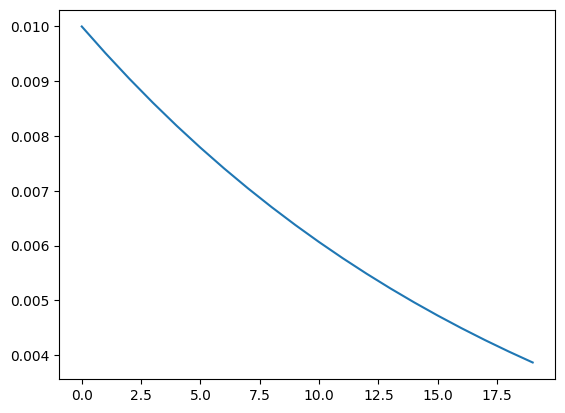

In [4]:
def lr_exp_decay(lr0, epoch, decay):
    return max(lr0 * np.exp(-decay*epoch),0.00001)

# graph
lrs = [lr_exp_decay(0.01, i, 0.05) for i in range(20)]
plt.plot(lrs)
plt.show()

In [5]:
myModel = Model()
save_name = "sin"
myOptim = optim.Adam(optim.get_parameters(myModel), lr=0.01)

def MSE(y, y_):
    return ((y - y_)**2).sum()  

def MAE(y, y_):
    return (y - y_).abs().mean()

loss_fxn = MAE
# loss_fxn = MSE
print(myModel)

(1, 2) [-0.04971406 -0.8106427 ]
(2, 2) [ 0.88600165  0.40740475 -0.63135374  0.11665945]
(2, 1) [-0.9436568 -0.9368828]



In [6]:
# train loop
total_preds = []
train_history = []
val_history = []
best = 0
patience = 0
best_val = np.inf
X_train, Y_train = [], []
epochs = 20
# main loop
for e in tqdm.tqdm(range(epochs)):
    myOptim.lr = lr_exp_decay(0.03, e, 0.05)
    X_train = np.array(X_train, dtype=np.float32)
    Y_train = np.array(Y_train, dtype=np.float32)
    # train loop
    Tensor.training = True
    total_loss = 0
    for i in range(100):
        x, y = next(sin_gen())
        x = Tensor(np.array(x,dtype=np.float32), requires_grad=False)
        y = Tensor(np.array(y,dtype=np.float32), requires_grad=False)
        myOptim.zero_grad()
        y_ = myModel(x)[0]
        loss = loss_fxn(y, y_)
        total_loss += loss.detach().numpy()/100
        loss.backward()
        myOptim.step()
    train_history.append(total_loss)
    print("Train loss", total_loss)

    # validation loop
    Tensor.training = False
    total_val_loss = 0
    temp=[]
    for i in range(100):
        x_val, y_val = next(sin_eval())
        x_val = Tensor(np.array(x_val,dtype=np.float32), requires_grad=False)
        y_val = Tensor(np.array(y_val,dtype=np.float32), requires_grad=False)
        y_val_ = myModel(x_val)[0]
        temp.append((x_val.numpy(), y_val_.numpy()))
        val_loss = loss_fxn(y_val, y_val_)
        total_val_loss += val_loss.detach().numpy()/100
    val_history.append(total_val_loss)
    print("Validation loss", total_val_loss)

    if total_val_loss < best_val:
        best_val = total_val_loss
        myModel.save(save_name)
        print("-----saved-----")


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss [0.41349885]


  5%|▌         | 1/20 [00:03<00:58,  3.08s/it]

Validation loss [0.28435796]
saving l1
saving mid
saving l2
-----saved-----
Train loss [0.25703794]


 10%|█         | 2/20 [00:06<00:56,  3.11s/it]

Validation loss [0.18139666]
saving l1
saving mid
saving l2
-----saved-----
Train loss [0.17581275]


 15%|█▌        | 3/20 [00:09<00:53,  3.13s/it]

Validation loss [0.13955508]
saving l1
saving mid
saving l2
-----saved-----
Train loss [0.16500552]


 20%|██        | 4/20 [00:12<00:50,  3.14s/it]

Validation loss [0.15517433]
Train loss [0.12976488]


 25%|██▌       | 5/20 [00:15<00:47,  3.14s/it]

Validation loss [0.20677847]
Train loss [0.16731304]


 30%|███       | 6/20 [00:18<00:43,  3.14s/it]

Validation loss [0.13731684]
saving l1
saving mid
saving l2
-----saved-----
Train loss [0.13869697]


 35%|███▌      | 7/20 [00:21<00:40,  3.15s/it]

Validation loss [0.12259156]
saving l1
saving mid
saving l2
-----saved-----
Train loss [0.12614273]


 40%|████      | 8/20 [00:25<00:37,  3.16s/it]

Validation loss [0.14365406]
Train loss [0.1220189]


 45%|████▌     | 9/20 [00:28<00:34,  3.17s/it]

Validation loss [0.09755266]
saving l1
saving mid
saving l2
-----saved-----
Train loss [0.10505494]


 50%|█████     | 10/20 [00:31<00:31,  3.18s/it]

Validation loss [0.11221098]
Train loss [0.12937342]


 55%|█████▌    | 11/20 [00:34<00:28,  3.18s/it]

Validation loss [0.09873046]
Train loss [0.10733712]


 60%|██████    | 12/20 [00:37<00:25,  3.18s/it]

Validation loss [0.10164496]
Train loss [0.10013179]


 65%|██████▌   | 13/20 [00:41<00:22,  3.19s/it]

Validation loss [0.09701273]
saving l1
saving mid
saving l2
-----saved-----
Train loss [0.10701139]


 70%|███████   | 14/20 [00:44<00:19,  3.20s/it]

Validation loss [0.09082551]
saving l1
saving mid
saving l2
-----saved-----
Train loss [0.10211768]


 75%|███████▌  | 15/20 [00:47<00:15,  3.20s/it]

Validation loss [0.14241143]
Train loss [0.13001968]


 80%|████████  | 16/20 [00:50<00:12,  3.20s/it]

Validation loss [0.13137765]
Train loss [0.08336341]


 85%|████████▌ | 17/20 [00:53<00:09,  3.21s/it]

Validation loss [0.07676344]
saving l1
saving mid
saving l2
-----saved-----
Train loss [0.08635277]


 90%|█████████ | 18/20 [00:57<00:06,  3.20s/it]

Validation loss [0.07317206]
saving l1
saving mid
saving l2
-----saved-----
Train loss [0.0903073]


 95%|█████████▌| 19/20 [01:00<00:03,  3.21s/it]

Validation loss [0.11858492]
Train loss [0.08257848]


100%|██████████| 20/20 [01:03<00:00,  3.18s/it]

Validation loss [0.0827011]


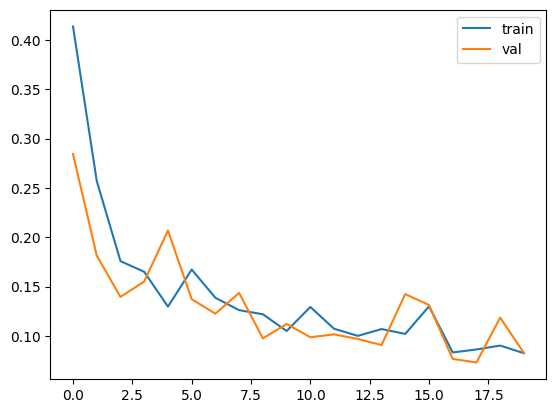

In [7]:
plt.plot(train_history, label="train")
plt.plot(val_history, label="val")
plt.legend()

In [8]:
#  load the best model
myModel.load(f"{save_name}.npz")
print(myModel)

loading l1
loading l2
loading mid
successfully loaded sin.npz
(1, 2) [-0.65044504 -2.1872694 ]
(2, 2) [ 2.064389   1.2550963 -0.967705   0.5561084]
(2, 1) [ 2.121131  -0.8998158]



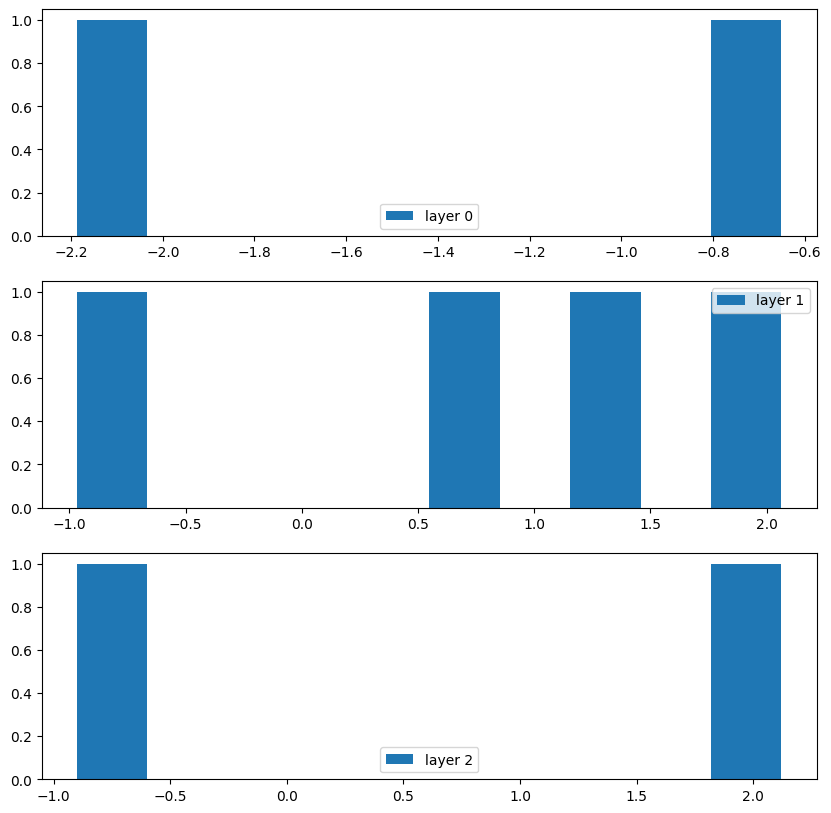

In [9]:
# plot distribution of weights per layer
plt.figure(figsize=(10,10))
for i in range(len(optim.get_parameters(myModel))):
    plt.subplot(len(optim.get_parameters(myModel)),1, i+1)
    plt.hist(optim.get_parameters(myModel)[i].detach().numpy().flatten(), label=f"layer {i}")
    plt.legend()
plt.show()

In [10]:
#  start the codegen process
import subprocess
#  generate the code DEBUG=5
cmd2 = f'CLANG=1 OPT=1 python3 compile.py --name={save_name}'
res2 = subprocess.run(cmd2, shell=True, capture_output=True, text=True)
print(res2.stdout)
C_name = res2.stdout.split(":")[-1].strip()
print("C name is ",C_name)
# save as .so
so_name = C_name[:-2] + ".so"
print("so name is ",so_name)

loading l1
loading l2
loading mid
successfully loaded sin.npz
model jitted successfully
starting codegen for model sin with 4 kernels
fxn E_1n1 args [buffer<1, dtypes.float>, buffer<1, dtypes.float>]
arg buffer<1, dtypes.float> 0
arg buffer<1, dtypes.float> 1
fxn E_2 args [buffer<2, dtypes.float>, buffer<1, dtypes.float>, buffer<2, dtypes.float>]
arg buffer<2, dtypes.float> 0
arg buffer<1, dtypes.float> 1
arg buffer<2, dtypes.float> 2
fxn r_2_2 args [buffer<2, dtypes.float>, buffer<2, dtypes.float>, buffer<4, dtypes.float>]
arg buffer<2, dtypes.float> 0
arg buffer<2, dtypes.float> 1
arg buffer<4, dtypes.float> 2
fxn r_2 args [buffer<1, dtypes.float>, buffer<2, dtypes.float>, buffer<2, dtypes.float>]
arg buffer<1, dtypes.float> 0
arg buffer<2, dtypes.float> 1
arg buffer<2, dtypes.float> 2
functions {'E_1n1': ' void E_1n1(float* restrict data0, const float* restrict data1) {\n{\n  float val1_0 = data1[0];\n  float val2_0 = 0.31831926107406616f;\n  float alu0 = (val1_0*val2_0);\n  data0[0

In [11]:
compile_cmd = f'gcc -shared -lm -fPIC -x c -o {so_name} {C_name}' # --rtlib=compiler-rt
print("COMILING....\n",compile_cmd)
res3 = subprocess.run(compile_cmd, shell=True, capture_output=True, text=True)
if len(res3.stderr) > 0:
    print("ERROR", res3.stderr)
else:
    print("SUCCESS", res3.stdout)

COMILING....
 gcc -shared -lm -fPIC -x c -o sin_1.so sin_1.c
SUCCESS 


In [12]:
import ctypes
my_model = ctypes.CDLL("./"+so_name)
my_model.forward.argtypes = [ctypes.c_float]
my_model.forward.restype = ctypes.c_float

#  test 
y = my_model.forward(0.5)
print(y)

0.5092934370040894


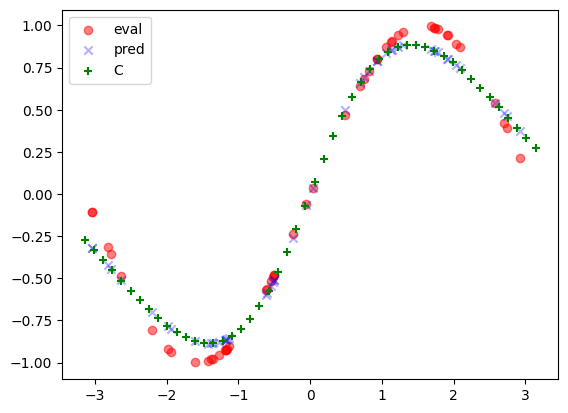

In [13]:
#  evaluate the model
X_eval, Y_eval, Y_pred, C_pred  = [], [], [], []
x = np.linspace(-np.pi, np.pi, 50, dtype=np.float32)
for i in range(50):
    x_, y_ = next(sin_eval())
    X_eval.append(x_)
    Y_eval.append(y_)
    out = myModel(Tensor(np.array(x_, dtype=np.float32), requires_grad=False)).numpy()
    Y_pred.append(out)
    res = my_model.forward(ctypes.c_float(x[i]))
    C_pred.append(res)

X_eval = np.array(X_eval, dtype=np.float32)
Y_eval = np.array(Y_eval, dtype=np.float32)
Y_pred = np.array(Y_pred, dtype=np.float32)
C_pred = np.array(C_pred, dtype=np.float32)

plt.scatter(X_eval, Y_eval, label = "eval", color = "red", alpha=0.5, marker='o')
plt.scatter(X_eval, Y_pred, label = "pred", color = "blue", alpha=0.3, marker='x')
plt.scatter(x, C_pred, label = "C", color = "green", alpha=1, marker='+')
plt.legend()
plt.show()